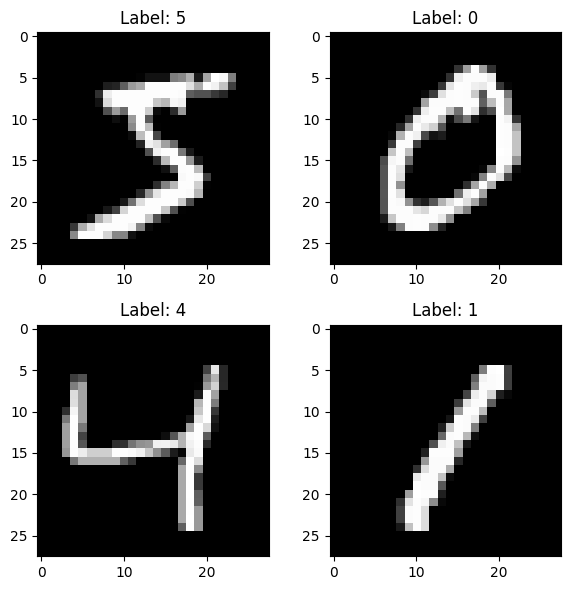

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)

X = mnist.data.astype('float32') / 255.0
y = mnist.target.astype('int')

X_train_full = X[:60000]
y_train_full = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

X_train = X_train_full[:50000]
y_train = y_train_full[:50000]
X_val = X_train_full[50000:]
y_val = y_train_full[50000:]


def show_samples():
    plt.figure(figsize=[6, 6])
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.title(f"Label: {y_train[i]}")
        plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.tight_layout()
    plt.show()


show_samples()

In [4]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """
    Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evaluate f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension
    return grad

In [5]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """

    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]

        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input)  # chain rule


In [6]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0, input)

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output * relu_grad

In [7]:
# some tests
x = np.linspace(-1, 1, 10 * 32).reshape([10, 32])
l = ReLU()
grads = l.backward(x, np.ones([10, 32]) / (32 * 10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0), \
    "gradient returned by your layer does not match the numerically computed gradient"

In [8]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <x*W> + b
        """
        self.learning_rate = learning_rate

        # initialize weights with small random numbers. 
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)

    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <x*W> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        # instead of standard python / for division, use np.divide that does !!!element-wise!!! division
        grad_input = np.dot(grad_output, self.weights.T)

        # compute gradient w.r.t. weights and biases

        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

In [11]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1, \
    "The initial weights must have zero mean and small variance. " \
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3, 4)

x = np.linspace(-1, 1, 2 * 3).reshape([2, 3])
l.weights = np.linspace(-1, 1, 3 * 4).reshape([3, 4])
l.biases = np.linspace(-1, 1, 4)

assert np.allclose(l.forward(x), np.array([[0.07272727, 0.41212121, 0.75151515, 1.09090909],
                                           [-0.90909091, 0.08484848, 1.07878788, 2.07272727]]))
print("Well done!")

Well done!


In [10]:
# To test the grads, we use gradients obtained via finite differences

x = np.linspace(-1, 1, 10 * 32).reshape([10, 32])
l = Dense(32, 64, learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(), x)
grads = l.backward(x, np.ones([10, 64]))

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [12]:
# test gradients w.r.t. params
def compute_out_given_wb(w, b):
    l = Dense(32, 64, learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1, 1, 10 * 32).reshape([10, 32])
    return l.forward(x)


def compute_grad_by_params(w, b):
    l = Dense(32, 64, learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1, 1, 10 * 32).reshape([10, 32])
    l.backward(x, np.ones([10, 64]) / 10.)
    return w - l.weights, b - l.biases


w, b = np.random.randn(32, 64), np.linspace(-1, 1, 64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w, b).mean(0).sum(), w)
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w, b).mean(0).sum(), b)
grad_w, grad_b = compute_grad_by_params(w, b)

assert np.allclose(numeric_dw, grad_w, rtol=1e-3, atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db, grad_b, rtol=1e-3, atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


In [14]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [15]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

In [16]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

In [17]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    for layer in network:
        output = layer.forward(input)
        activations.append(output)
        input = output
    assert len(activations) == len(network)
    return activations


def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [18]:
def train(network, X, y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first, 
    propagating the gradient of input to previous layers.

    After you called backward for all layers, all Dense layers have already made one gradient step.
    """

    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    current_grad = loss_grad
    for i in range(len(network) - 1, -1, -1):
        current_grad = network[i].backward(layer_inputs[i], current_grad)

    return np.mean(loss)

In [19]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for batch_idx in range(int(len(inputs) / batchsize)):
        start_idx = batch_idx * batchsize
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [20]:
from IPython.display import clear_output

train_log = []
val_log = []

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9801


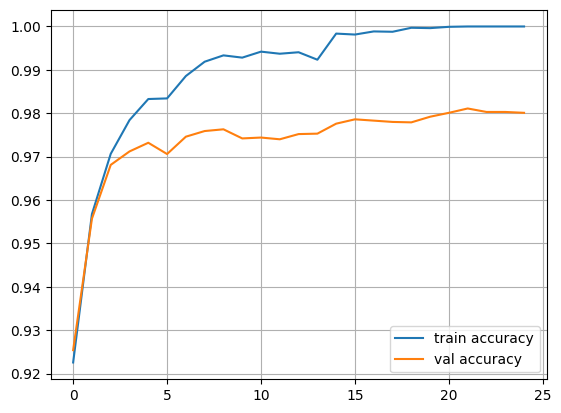

In [21]:
for epoch in range(25):

    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

#

In [22]:
activations = forward(network, X_val)

In [23]:
# layer before the classification, take 1000 samples
f = activations[-2][:1000]
labels = y_val[:1000]
print(f.shape)

(1000, 200)


In [25]:
import scipy.spatial

# compute pairwise distances
d = scipy.spatial.distance_matrix(f, f)

In [26]:
# extract distances for the 'positive pairs' (same class), 
# extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b = np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
# labels
c = np.zeros((len(labels), len(labels)))
c[a == b] = 1
pind = np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a != b] = 1
nind = np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))
# (5006741.0, 44988259.0) -- for the whole X_val
# (49715.0 449785.0)      -- for X_val[:1000]

pd = d[pind == 1]
nd = d[nind == 1]

49715.0 449785.0


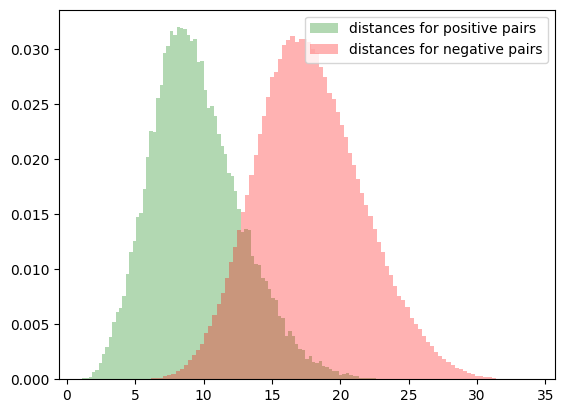

In [27]:
hp, _, _ = plt.hist(pd, bins=100, color='green', alpha=0.3, weights=np.ones(len(pd)) / len(pd),
                    label='distances for positive pairs')
hn, _, _ = plt.hist(nd, bins=100, color='red', alpha=0.3, weights=np.ones(len(nd)) / len(nd),
                    label='distances for negative pairs')
plt.legend(loc='best')

In [28]:
# Let's compute the bhattacharyya coefficient
np.sum(np.sqrt(hp * hn))
# 0.8098678769262441 for the whole X_val
# 0.9204532401423291 for X_val[:1000]

np.float64(0.8938420001138005)

(1000, 2)


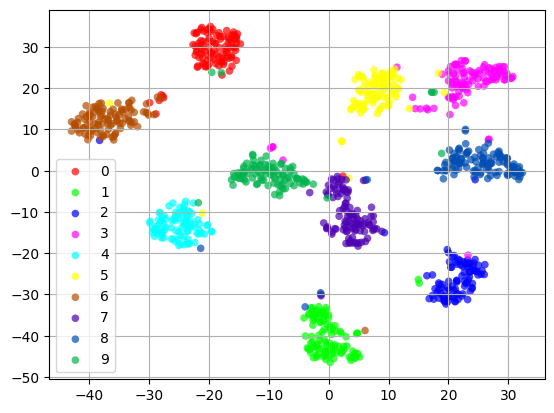

In [29]:
# Look at the t-SNE visualizations: classes are grouped

import sklearn.manifold
import numpy as np
from sklearn.manifold import TSNE

X = np.array(f)
X_embedded = TSNE(n_components=2).fit_transform(X)

print(X_embedded.shape)
coord1 = X_embedded[:, 0]
coord2 = X_embedded[:, 1]
colors = labels

fig, ax = plt.subplots()

colors = [[1, 0, 0],
          [0, 1, 0],
          [0, 0, 1],
          [1, 0, 1],
          [0, 1, 1],
          [1, 1, 0],
          [0.7, 0.3, 0],
          [0.3, 0, 0.7],
          [0, 0.3, 0.7],
          [0, 0.7, 0.3]
          ]

# np.random.random([len(set(labels)), 3])
for l in set(labels):
    coord1_l = coord1[labels == l]
    coord2_l = coord2[labels == l]
    # scale = 200.0 * rand(n)
    ax.scatter(coord1_l, coord2_l, c=[colors[l] for i in range(len(coord1_l))],
               s=30, label=l,
               alpha=0.7, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

# спасибо вам, Алсу Рафаэлевна, за чудесный семестр изучения информатики!!!